In [30]:
import wrangle
import pandas as pd
import numpy as np
import modeling

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector


import matplotlib.pyplot as plt

In [2]:
train, validate, test = wrangle.wrangle_zillow()

In [3]:
train.shape, validate.shape, test.shape

((25908, 17), (8637, 17), (8637, 17))

In [4]:
train.describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
parcelid,25908,13007162,2586803,10711855,11503757,12653312,14128263,162960814
bathrooms,25908,2,0,0,2,2,2,5
bedrooms,25908,3,0,0,3,3,4,6
sqft,25908,1722,666,128,1240,1573,2073,5256
fireplacecnt,25908,0,0,0,0,0,0,4
garagecarcnt,25908,0,0,0,0,0,2,9
lotsize,25908,7160,3127,236,5457,6624,8039,21663
yearbuilt,25908,1962,21,1885,1950,1960,1977,2016
poolcnt,25908,0,0,0,0,0,0,1
logerror,25908,0,0,-4,0,0,0,3


In [5]:
# scale features
train.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'sqft', 'county', 'fireplacecnt',
       'garagecarcnt', 'lotsize', 'yearbuilt', 'poolcnt', 'logerror', 'tract',
       'tax_value', 'Orange', 'Ventura', '4plusBath', '3to5garage'],
      dtype='object')

In [35]:
features = ['bathrooms', 'bedrooms', 'sqft']

In [36]:
X_train = train[features]
X_validate = validate[features]

In [37]:
# create MinMaxScaler and fit to train
scaler = MinMaxScaler()
X_train[features] = scaler.fit_transform(X_train[features])

In [38]:
# fit validation to scaler fit on train data
X_validate[features] = scaler.transform(X_validate[features])

In [39]:
# create y files as dataframe to append results
y_train = train.tax_value
y_validate = validate.tax_value

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)




In [40]:
# 1. Predict value_pred_mean
value_pred_mean = y_train['tax_value'].mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# 2. compute value_pred_median
value_pred_median = y_train['tax_value'].median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

# 3. RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  233115.06 
Validate/Out-of-Sample:  234810.22
RMSE using Median
Train/In-Sample:  235121.87 
Validate/Out-of-Sample:  236574.11


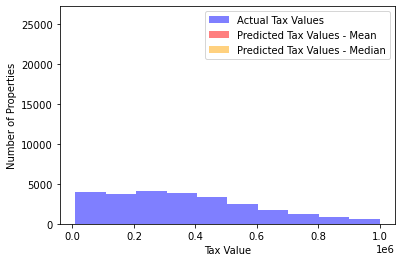

In [41]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_train.value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Values - Mean")
plt.hist(y_train.value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Values - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

In [42]:

# create target scaler and scale target variable
target_scaler = QuantileTransformer(output_distribution='normal')

y_train[['tax_value']] = target_scaler.fit_transform(y_train[['tax_value']])
y_validate[['tax_value']] = target_scaler.transform(y_validate[['tax_value']])

# LR model

In [43]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['tax_value'])

# predict train
y_train['value_pred_lm'] = lm.predict(X_train)
y_train['value_pred_lm'] = target_scaler.inverse_transform(y_train[['value_pred_lm']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)
y_validate['value_pred_lm'] = target_scaler.inverse_transform(y_validate[['value_pred_lm']])

# evaluate: rmse
rmse_val = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  362752.64660611347 
Validation/Out-of-Sample:  236574.1127038702


In [44]:
y_validate

,tax_value,value_pred_mean,value_pred_median,value_pred_lm
31596,-2.051723,368653.892234,338000.0,326317.524142
111,0.394148,368653.892234,338000.0,458689.627995
27405,-0.253717,368653.892234,338000.0,480625.095393
49945,0.420364,368653.892234,338000.0,358463.796636
43312,-0.298589,368653.892234,338000.0,305846.473050
...,...,...,...,...
5331,-0.403355,368653.892234,338000.0,433101.368446
1405,-0.237968,368653.892234,338000.0,384385.197502
26015,-0.974279,368653.892234,338000.0,350151.619091
52100,0.290618,368653.892234,338000.0,600684.022568


# LassoLars

In [45]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train['tax_value'])

# predict train
y_train['value_pred_llars'] = lars.predict(X_train)
y_train['value_pred_llars'] = target_scaler.inverse_transform(y_train[['value_pred_llars']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_llars)**(1/2)

# predict validate
y_validate['value_pred_llars'] = lars.predict(X_validate)
y_validate['value_pred_llars'] = target_scaler.inverse_transform(y_validate[['value_pred_llars']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_llars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  337881.795367403 
Validation/Out-of-Sample:  337881.80370516755


# TweedieRegressor (GLM)

In [46]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0) # changed power to 0 since we normalized the target

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train['tax_value'])

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)
y_train['value_pred_glm'] = target_scaler.inverse_transform(y_train[['value_pred_glm']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)
y_validate['value_pred_glm'] = target_scaler.inverse_transform(y_validate[['value_pred_glm']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  362759.59546575823 
Validation/Out-of-Sample:  363186.5882477455


# Polynomial Regression

In [47]:
# create the model object
pf = PolynomialFeatures(degree=2)

# create the X and y datasets
X2_train = train[features]

X2_validate = validate[features]

In [48]:
# fit the model to our training data. We must specify the column in y_train, 
lm2 = LinearRegression(normalize=True)

# since we have converted it to a dataframe from a series! 
lm2.fit(X2_train, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X2_train)
y_train['value_pred_lm2'] = target_scaler.inverse_transform(y_train[['value_pred_lm2']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X2_validate)
y_validate['value_pred_lm2'] = target_scaler.inverse_transform(y_validate[['value_pred_lm2']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  362752.6466061134 
Validation/Out-of-Sample:  363180.30429015815


In [49]:
kbest = SelectKBest(score_func=f_regression, k=6)
kbest.fit(X_train, y_train.tax_value) 
X_train.columns[kbest.get_support()].tolist()

ValueError: k should be >=0, <= n_features = 3; got 6. Use k='all' to return all features.

In [28]:
X_train

,bathrooms,bedrooms,sqft,fireplacecnt,garagecarcnt,lotsize,yearbuilt,poolcnt,Orange,Ventura,4plusBath,3to5garage
50660,2.0,4.0,1444.0,0.0,0.0,7490.0,1964.0,1.0,0,0,0,0
14557,2.0,3.0,1545.0,0.0,0.0,8807.0,1951.0,0.0,0,0,0,0
47007,3.0,4.0,2286.0,0.0,2.0,8400.0,1965.0,0.0,1,0,0,0
26586,2.0,3.0,1431.0,1.0,2.0,11100.0,1963.0,0.0,0,1,0,0
50383,2.5,3.0,1463.0,0.0,2.0,4400.0,1993.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
637,3.0,4.0,2694.0,2.0,2.0,10148.0,1986.0,0.0,0,1,0,0
37673,2.5,3.0,1385.0,0.0,2.0,2032.0,1984.0,0.0,1,0,0,0
32816,1.5,2.0,1350.0,1.0,2.0,2062.0,1973.0,0.0,1,0,0,0
23077,2.0,3.0,1266.0,0.0,0.0,13351.0,1959.0,0.0,0,0,0,0
